In [15]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 12, 20)

df = web.DataReader("BILI", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-14,80.870003,77.040001,78.405998,78.199997,5022600,78.199997
2020-12-15,80.800003,76.000000,80.650002,76.660004,3899900,76.660004
2020-12-16,81.809998,77.970001,77.970001,78.830002,3695300,78.830002
2020-12-17,82.839996,78.599998,79.410004,82.190002,3776100,82.190002
2020-12-18,86.599998,83.150002,84.190002,84.680000,6029000,84.680000


In [16]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [8]:
mavg

Date
2018-03-28        NaN
2018-03-29        NaN
2018-04-02        NaN
2018-04-03        NaN
2018-04-04        NaN
               ...   
2020-12-14    48.5734
2020-12-15    48.9390
2020-12-16    49.3141
2020-12-17    49.7274
2020-12-18    50.1565
Name: Adj Close, Length: 689, dtype: float64

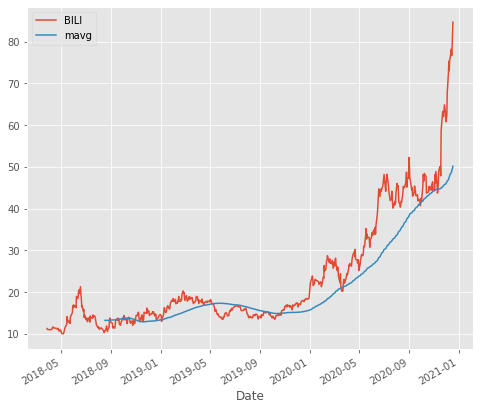

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='BILI')
mavg.plot(label='mavg')
plt.legend()

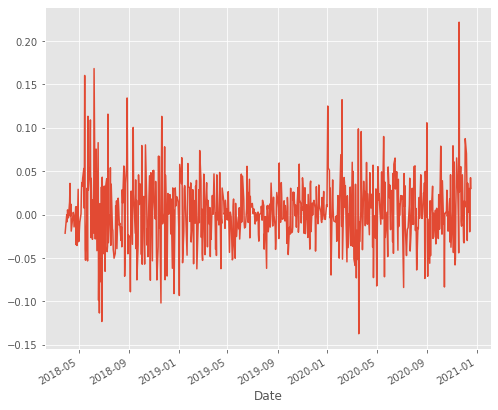

In [19]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [22]:
dfcomp = web.DataReader(['BILI', 'IQ', 'HUYA'],'yahoo',start=start,end=end)['Adj Close']

In [23]:
dfcomp

Symbols,BILI,IQ,HUYA
Date,,,
2018-03-28,11.240000,NaN,NaN
2018-03-29,11.000000,15.550000,NaN
2018-04-02,11.000000,15.700000,NaN
2018-04-03,10.910000,16.000000,NaN
2018-04-04,10.970000,15.670000,NaN
...,...,...,...
2020-12-14,78.199997,22.600000,20.200001
2020-12-15,76.660004,22.309999,20.200001
2020-12-16,78.830002,18.105000,20.430000


In [24]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

In [25]:
corr

Symbols,BILI,IQ,HUYA
Symbols,,,
BILI,1.000000,0.450263,0.457529
IQ,0.450263,1.000000,0.501345
HUYA,0.457529,0.501345,1.000000


Text(0, 0.5, 'Returns IQ')

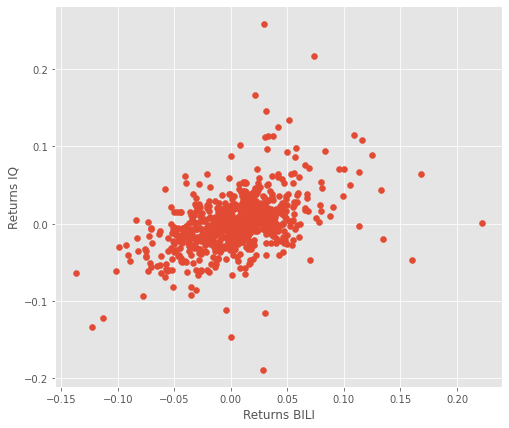

In [27]:
plt.scatter(retscomp.BILI, retscomp.IQ)
plt.xlabel('Returns BILI')
plt.ylabel('Returns IQ')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1286c7a00>,
      dtype=object)

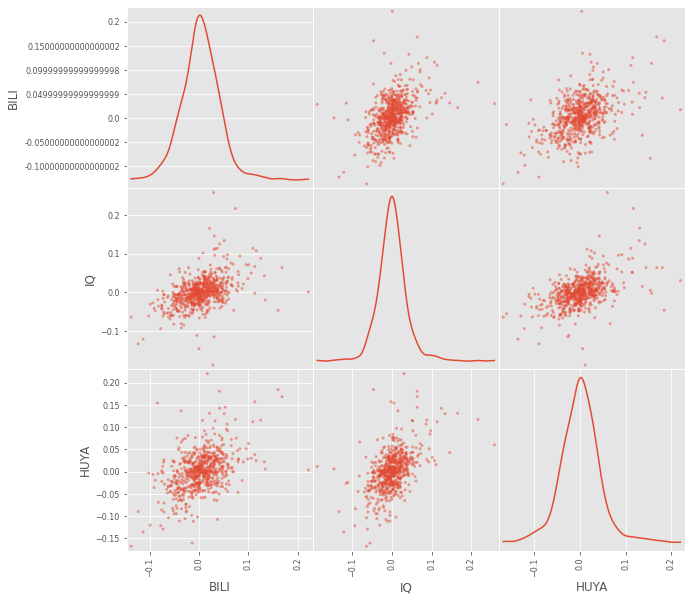

In [29]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10))

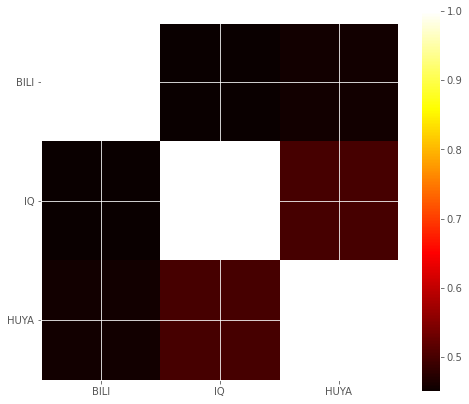

In [30]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

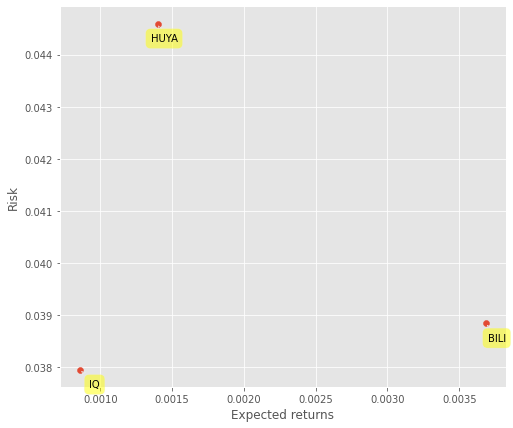

In [31]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [34]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [35]:
dfreg

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2018-03-28,11.240000,23929600,14.590751,14.693873
2018-03-29,11.000000,5863900,10.454551,-4.347826
2018-04-02,11.000000,2771000,5.363638,-0.452490
2018-04-03,10.910000,2509600,6.498622,-5.130436
2018-04-04,10.970000,1498200,4.831356,2.046514
...,...,...,...,...
2020-12-14,78.199997,5022600,4.897701,-0.262737
2020-12-15,76.660004,3899900,6.261418,-4.947300
2020-12-16,78.830002,3695300,4.871237,1.102989


In [40]:
import math
import numpy as np
from sklearn import preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge())])